In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from scipy.ndimage import gaussian_filter

import helpers

import pandas as pd
# import numpy as np
from PIL import Image
import PIL
import matplotlib as mpl

# import matplotlib.pyplot as plt
# from skimage.filters import meijering, sato, frangi, hessian
# from skimage.measure import label, regionprops
from skimage import exposure
# from sklearn import decomposition
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
# import helpers

In [2]:
filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'

img = cv2.imread(filename,0)

# fix brightness and shadowing issues
# https://stackoverflow.com/questions/44047819/increase-image-brightness-without-overflow/44054699#44054699

# dilated_img = cv2.dilate(img, np.ones((7,7), np.uint8)) 
# bg_img = cv2.medianBlur(dilated_img, 21)
# diff_img = 255 - cv2.absdiff(img, bg_img)
# norm_img = diff_img.copy() # Needed for 3.x compatibility
# cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

# filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'
# im = Image.open(filename)
# imarr = np.array(im)

norm_img = helpers.fix_brightness(img)

In [3]:

# apply histogram equalization for vesicle picking
# https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py
imarr_hist = exposure.equalize_hist(norm_img)


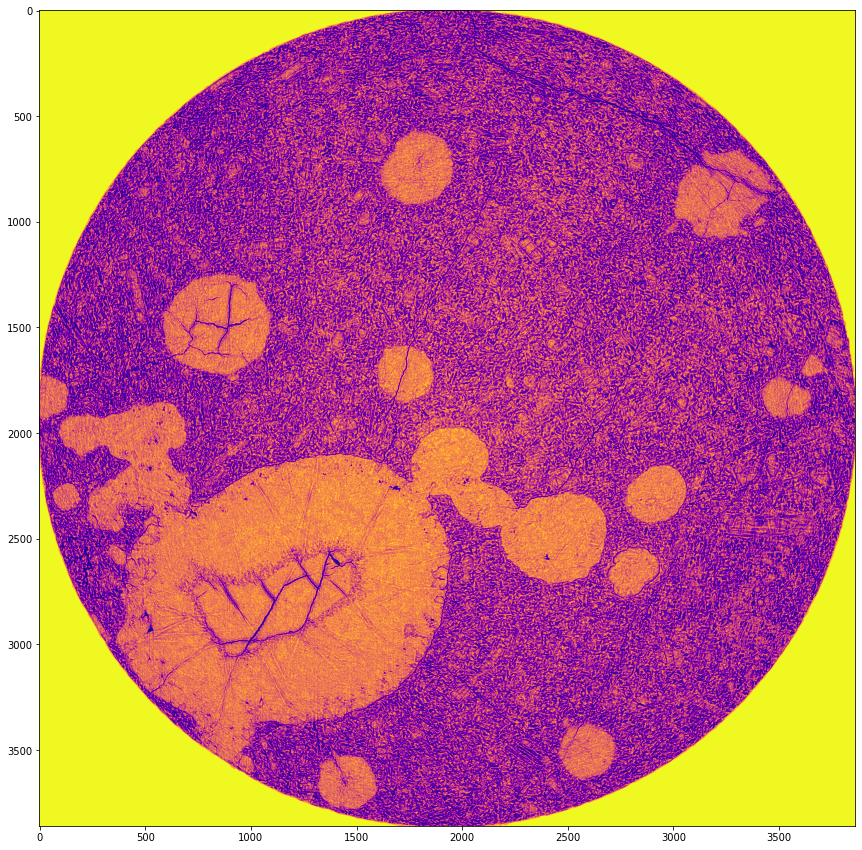

In [4]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(imarr_hist, cmap='plasma')

In [5]:
# remove data from outside of core

# imarr_maskradius = helpers.remove_data_based_on_radius(imarr, mask_value=np.nan)
imarr_hist = helpers.remove_data_based_on_radius(imarr_hist, mask_value=np.nan)

In [6]:
# try different gaussian blurring based on sigma values

gauss_sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# blurs = [gaussian_filter(imarr_maskradius, sigma=sigma) for sigma in gauss_sigmas]
blurs = [gaussian_filter(imarr_hist, sigma=sigma) for sigma in gauss_sigmas]

In [7]:
# calculate peaks

peaks_etc = [helpers.get_peaks_means_stds(b, height=1e3, width=4) for b in blurs]

# label peaks
peak_labled = [helpers.label_by_peaks(blurs[s-1], peaks_etc[s-1]) for s in gauss_sigmas]

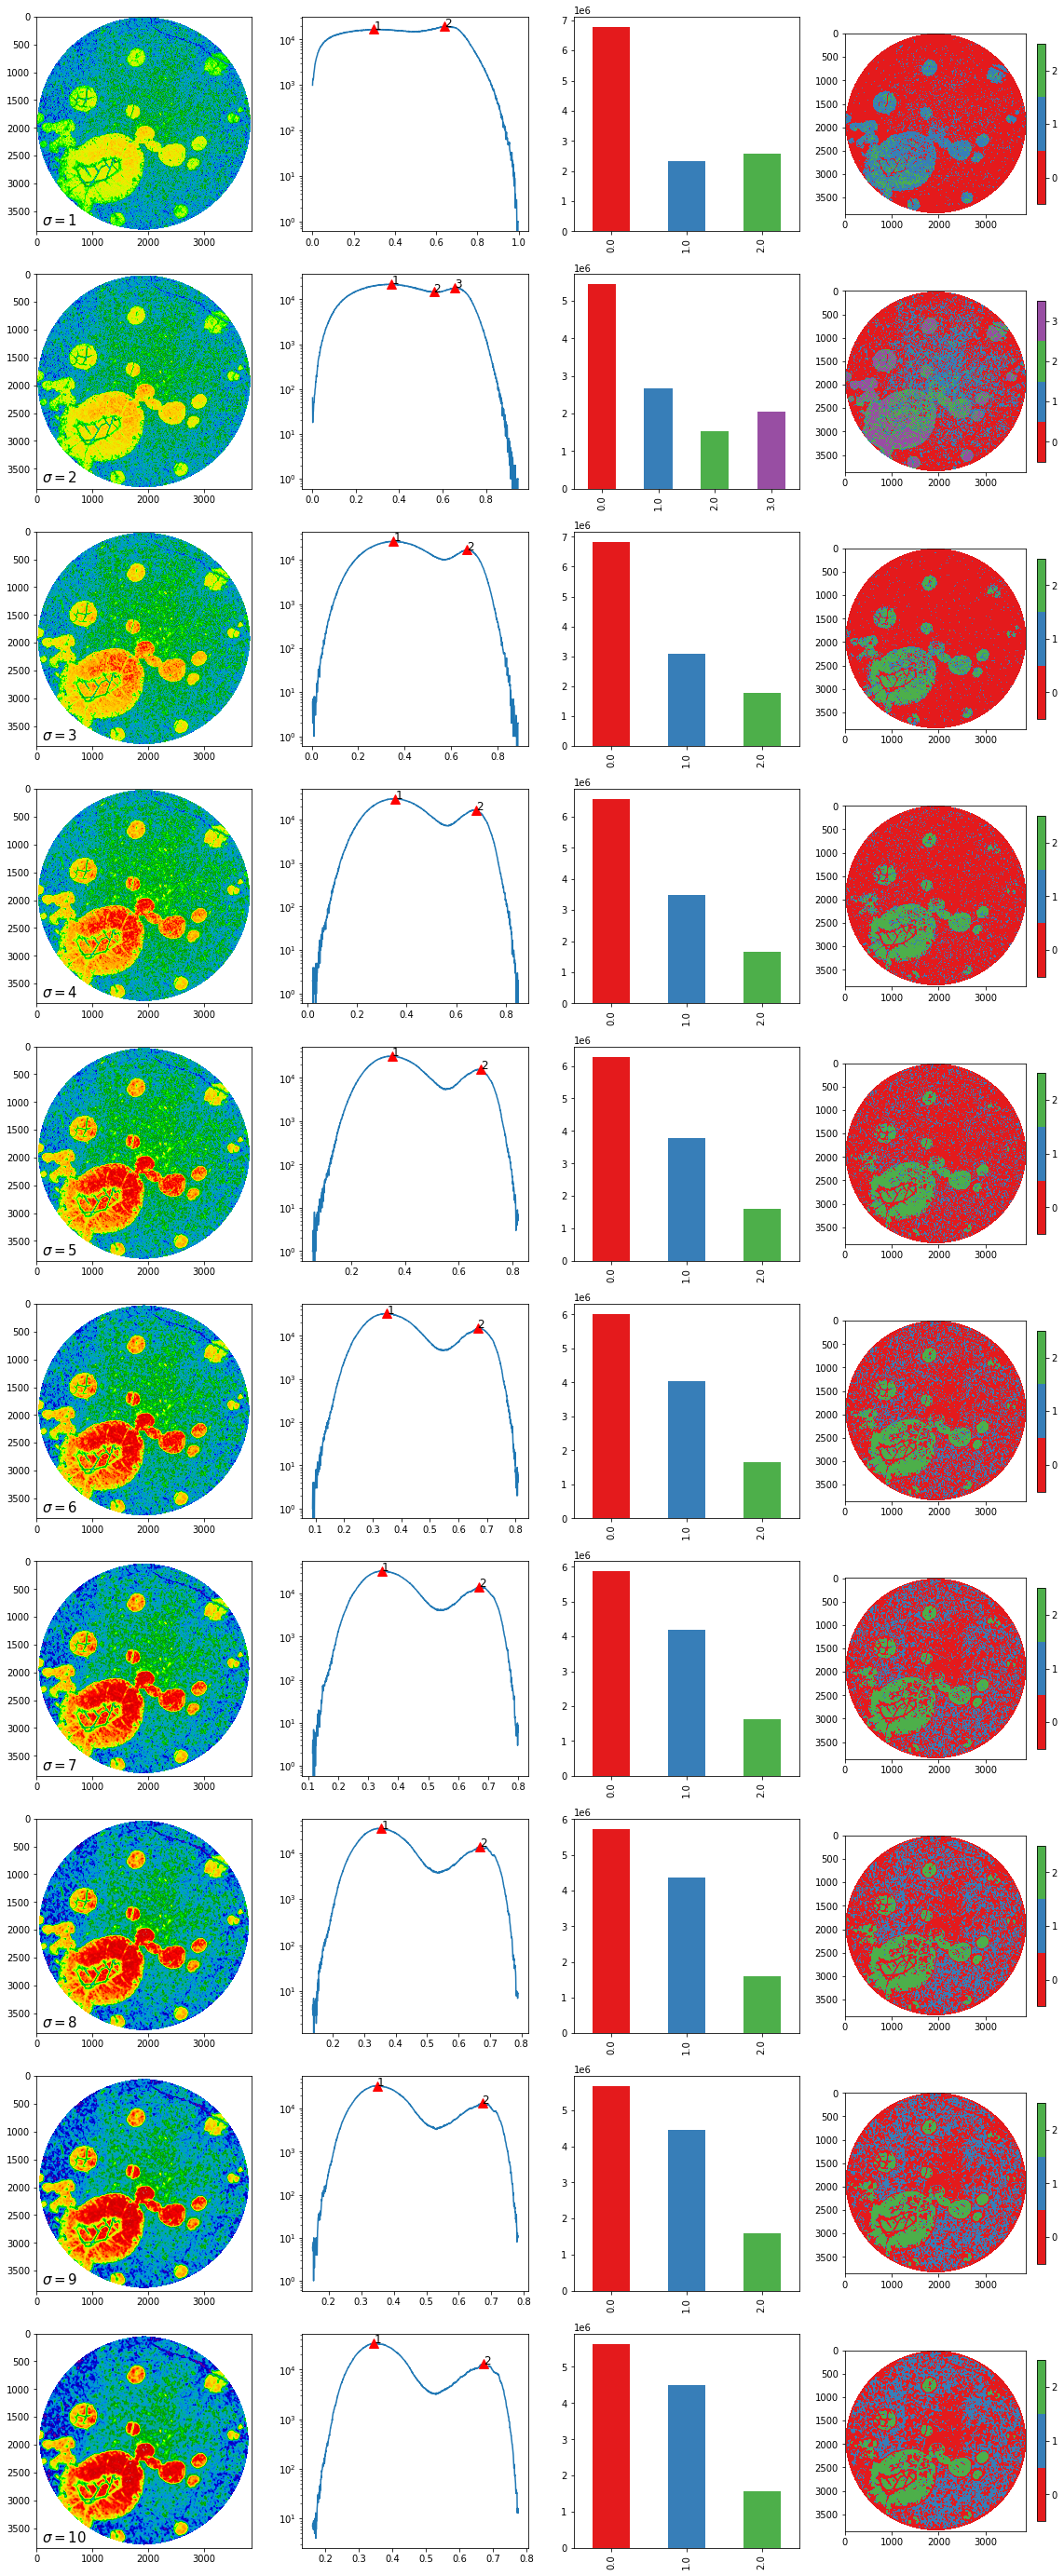

In [8]:
# plot figures that include gaussian blurred image, histogram of CT values with peaks assigned, count of each peak by peak number, and labeled image

fig, ax = plt.subplots(len(gauss_sigmas), 4, figsize=(20, 5*len(gauss_sigmas)))

s = 1
for a, b in zip(ax[:,0], blurs):
    a.imshow(b, cmap='nipy_spectral')
    a.text(s=r'$\sigma=$'+str(s), x=100, y=3750, fontsize=15)
    s+=1
    
for a, p in zip(ax[:,1], peaks_etc):
    x = p['edges'][:-1]
    a.plot(x, p['hist'])
    a.plot(x[p['peaks']], p['hist'][p['peaks']], marker='^', markersize=10, linewidth=0, color='red')
    
    n = 1
    for x, y in zip(x[p['peaks']], p['hist'][p['peaks']]):
        a.text(s=str(n), x=x, y=y, fontsize=12)
        n += 1
    a.set_yscale('log')
    
for a, a2, p, p2 in zip(ax[:,2], ax[:,3], peak_labled, peaks_etc):
    n = len(p2['peaks'])
    bounds = np.arange(0, n+1, 1)
#     print(bounds)

    cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(bounds), len(bounds))
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     norm = mpl.colors.BoundaryNorm(np.arange(0, len(bounds)+1, 1), cmap.N)
    
    bins = p.flatten()
    bincnt = pd.value_counts(bins).sort_index()
#     print(bincnt)
    bincnt.plot.bar(ax=a, color=[cmap(b/bounds.max()) for b in bounds])
    
#     cbar = a2.imshow(p, cmap=cmap)
#     cbar = a2.imshow(p, cmap=cmap, norm=norm)
    cbar = a2.imshow(p, cmap=cmap, vmin=0, vmax=bounds.max())
    
    step = (bounds[-1]/bounds.shape[0])/2
    ticks = [(b*bounds.max()/bounds.shape[0])+step for b in bounds]
    
    cbar = fig.colorbar(cbar, ax=a2, shrink=0.75, ticks=ticks)
    cbar.ax.set_yticklabels(bounds)
    
# fig.tight_layout()
# fig.savefig('boom.png', dpi=500, bbox_inches='tight')

0.78
[0. 1.]


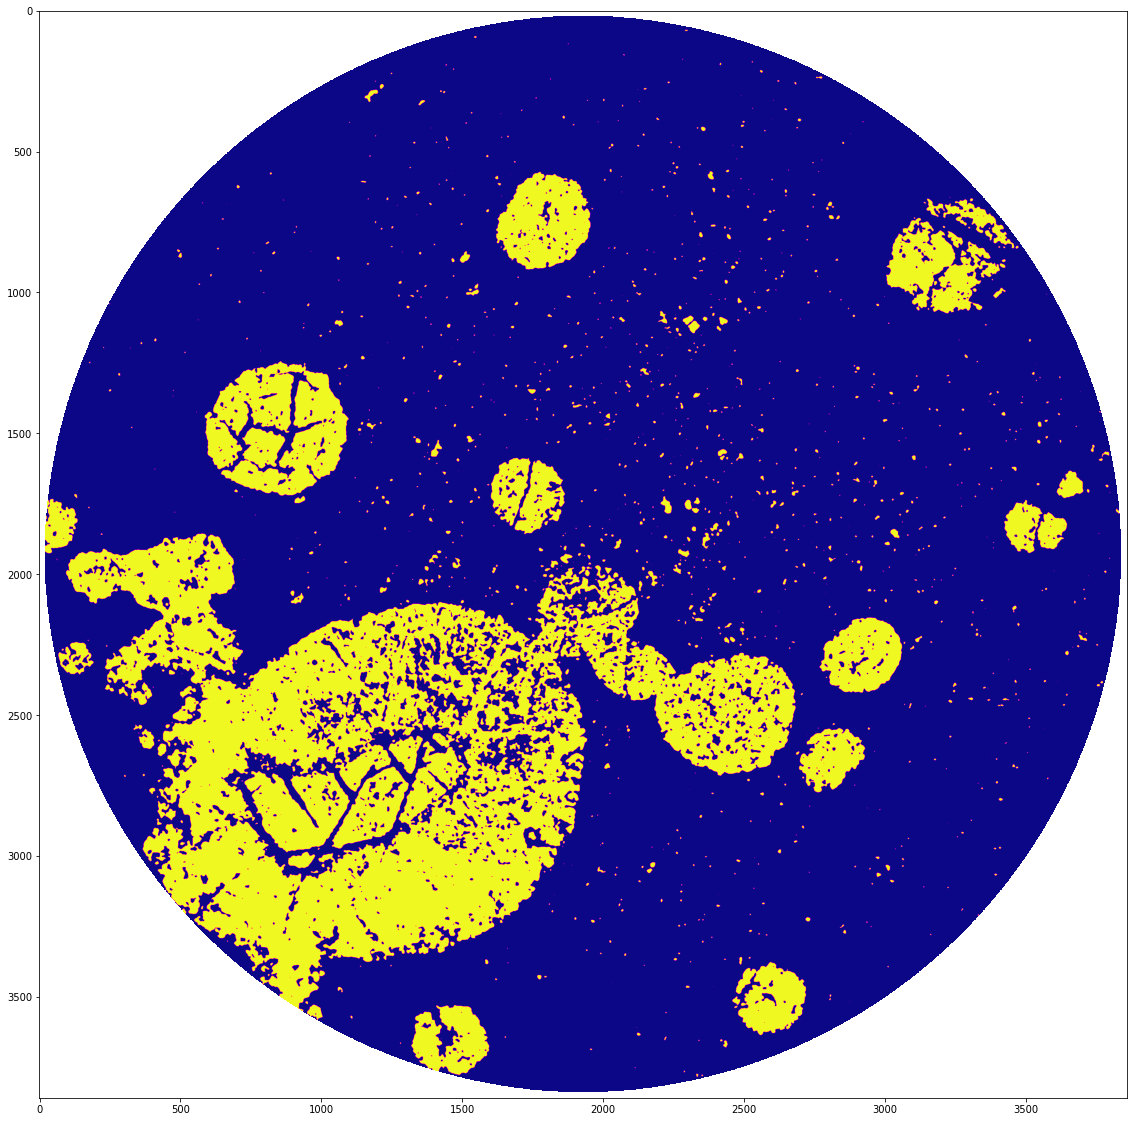

In [46]:
index = 0

n = len(peaks_etc[index]['peaks'])
bounds = np.arange(0, n+1, 1)

cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(bounds), len(bounds))

bins = p.flatten()
bincnt = pd.value_counts(bins).sort_index()

step = (bounds[-1]/bounds.shape[0])/2
ticks = [(b*bounds.max()/bounds.shape[0])+step for b in bounds]


fig, ax = plt.subplots(figsize=(20, 20))

z = np.copy(peak_labled[index])
z[z == 1] = 0
# z[z == 2] = 3
# z[z == 3] = 0

z = gaussian_filter(z, sigma=4)

# z[z>=0.5] = 2
# z[z<1] = 0

# find local minima in histogram to separate vesicles from noise
h, e = np.histogram(z.flatten(), bins=np.linspace(0, 2, 201))
splitter = e[argrelextrema(h, np.less, order=10)][0]
print(splitter)

z[z >= splitter] = 1
z[z < splitter] = 0

ax.imshow(z, cmap='plasma')
# cbar = ax.imshow(z, cmap=cmap, vmin=0, vmax=bounds.max())
print(np.unique(z[~np.isnan(z)]))

# cbar = fig.colorbar(cbar, ax=ax, shrink=0.75, ticks=ticks)
# cbar.ax.set_yticklabels(bounds)

In [27]:
from scipy.signal import argrelextrema


array([0.78])

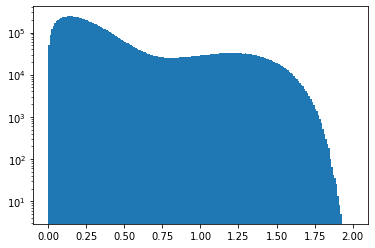

In [39]:
# example histogram to demonstrate peak splitting

x = plt.hist(z.flatten(), bins=np.linspace(0, 2, 201))
plt.yscale('log')
x[1][argrelextrema(x[0], np.less, order=10)]
# plt.plot(x[1][:-1], np.gradient(x[0]))


In [13]:
# from skimage.segmentation import flood, flood_fill


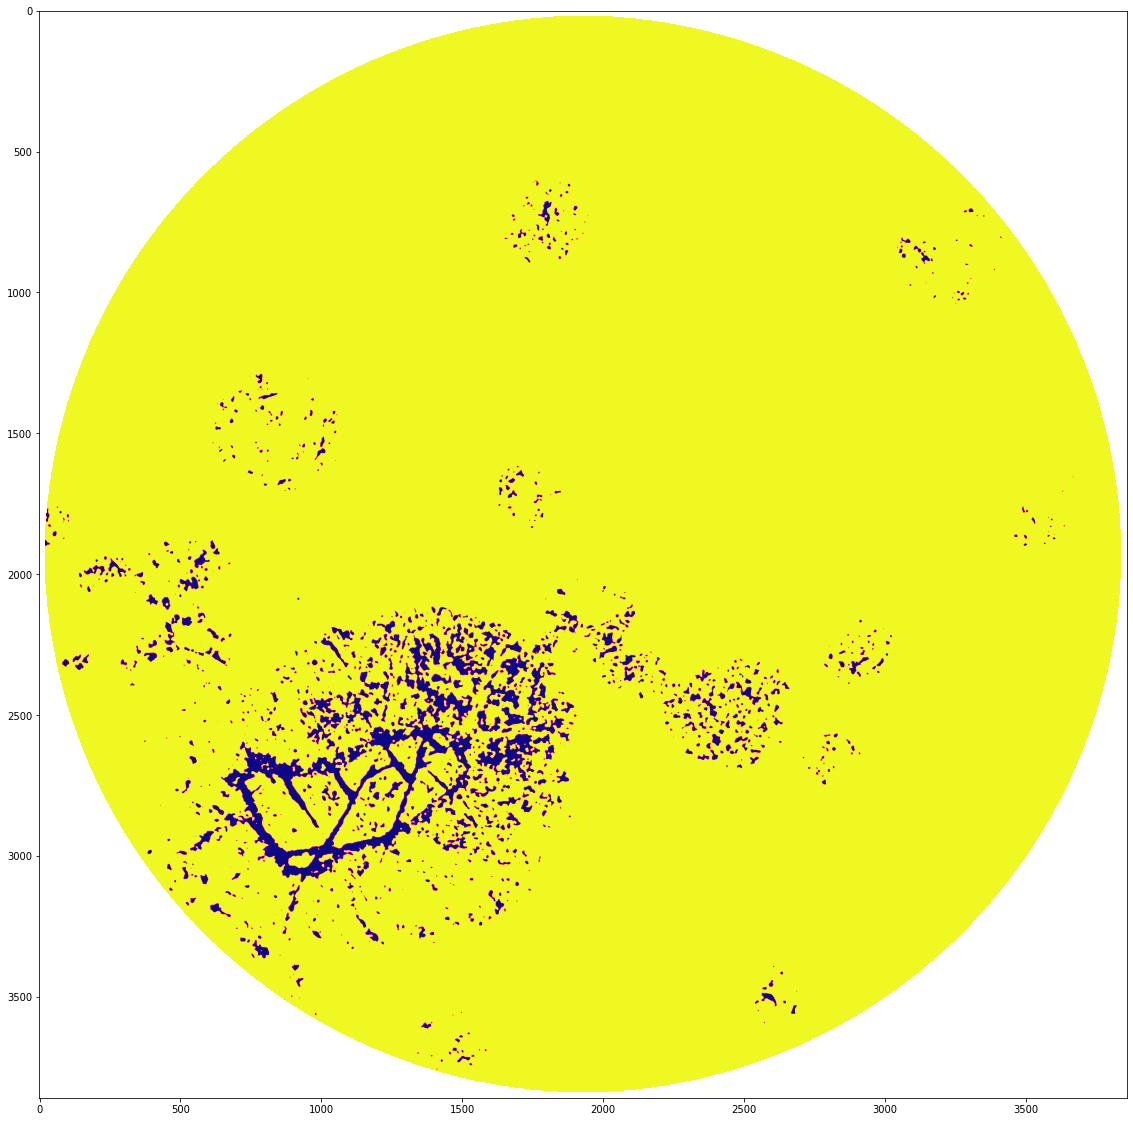

In [17]:
# zflood = flood_fill(z, (2000, 2000), 1)

# fig, ax = plt.subplots(figsize=(20, 20))

# ax.imshow(zflood, cmap='plasma')

In [12]:
# image = PIL.Image.fromarray(z)

# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


TypeError: Expected Ptr<cv::UMat> for argument 'src'